# Inferences

I'm going to keep track of model progress in this notebook. After X number of steps, I will extract inferences and view the predictions. 

In [1]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
import glob
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

# 10000 steps of training

In [13]:
INPUT_PATH = "./global-wheat-detection/inferences.tfrecord"

In [64]:
def prepare_df(input_path, height = 1024, width = 1024):
    
    def rescale(x, scalar):
    
        return(int(x * scalar))
    
    detections = pd.DataFrame(columns=['score', 'label_idx', 'xmin', 'xmax', 'ymin', 'ymax', 'filename'])
    
    dataset = tf.data.TFRecordDataset(input_path)
    
    for example in dataset:
        
        parsed_img = tf.train.Example.FromString(example.numpy())
        
        feature_dict = parsed_img.features.feature
        
        score = feature_dict["image/detection/score"].float_list.value
        
        score = [x for x in score if x >= 0.50]
        
        to_keep = len(score)
        
        detections = detections.append({'score': score,
                                    
                    'label_idx': feature_dict['image/detection/label'].int64_list.value[:to_keep],
                                    
                    'xmin': feature_dict['image/detection/bbox/xmin'].float_list.value[:to_keep],
                                    
                    'xmax': feature_dict['image/detection/bbox/xmax'].float_list.value[:to_keep],
                                    
                    'ymin': feature_dict['image/detection/bbox/ymin'].float_list.value[:to_keep],
                                    
                    'ymax': feature_dict['image/detection/bbox/ymax'].float_list.value[:to_keep],
                                    
                    'filename': feature_dict['image/filename'].bytes_list.value[0].decode()}, ignore_index=True)
        
    converted_obs = []

    for i in range(len(detections)):

        for j in range(len(detections.iloc[i]["score"])):

            d = {}

            d["filename"] = detections.iloc[i]["filename"]

            d["score"] = detections.iloc[i]["score"][j]

            d["xmin"] = detections.iloc[i]["xmin"][j]

            d["xmax"] = detections.iloc[i]["xmax"][j]

            d["ymin"] = detections.iloc[i]["ymin"][j]

            d["ymax"] = detections.iloc[i]["ymax"][j]

            converted_obs.append(d)
            
    inferences = pd.DataFrame(converted_obs)
    
    inferences["ymin"] = inferences.ymin.apply(lambda x: rescale(x, height))

    inferences["ymax"] = inferences.ymax.apply(lambda x: rescale(x, height))

    inferences["xmin"] = inferences.xmin.apply(lambda x: rescale(x, width))

    inferences["xmax"] = inferences.xmax.apply(lambda x: rescale(x, width))
    
    return(inferences)

def plot_examples(df: pd.DataFrame, file: str, input_dir: str):
    
    fig, ax = plt.subplots(figsize = (12, 12))
        
    partial = df[df.filename == file].reset_index(drop = True)

    with tf.io.gfile.GFile(os.path.join(input_dir, file), "rb") as f:

        encoded = f.read()

    img = Image.open(BytesIO(encoded))

    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    for _, row in partial.iterrows():
        
        cv2.rectangle(img_cv, (row.xmin, row.ymin), (row.xmax, row.ymax), (255, 0, 0), 2)

    ax.set_axis_off()

    ax.imshow(img_cv)

    ax.set_title("Test Image")

In [20]:
inferences = prepare_df(INPUT_PATH)

In [24]:
all_files = list(inferences.filename.unique())

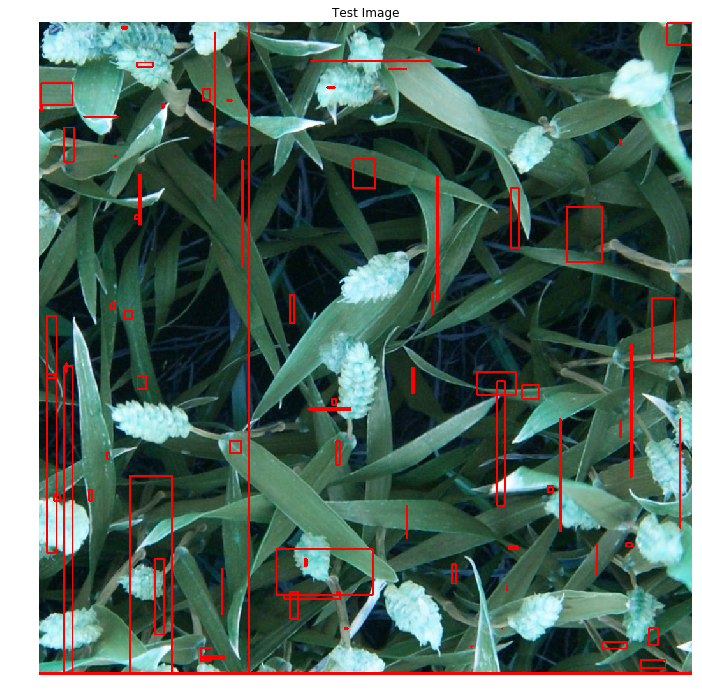

In [25]:
input_dir = "./global-wheat-detection/test"

plot_examples(inferences, all_files[0], input_dir)

These are terrible. Obviously we need more training.

# 60000 Steps

In [65]:
INPUT_PATH = "./global-wheat-detection/inferences60000.tfrecord"

In [66]:
inferences = prepare_df(INPUT_PATH)

In [67]:
all_files = list(inferences.filename.unique())

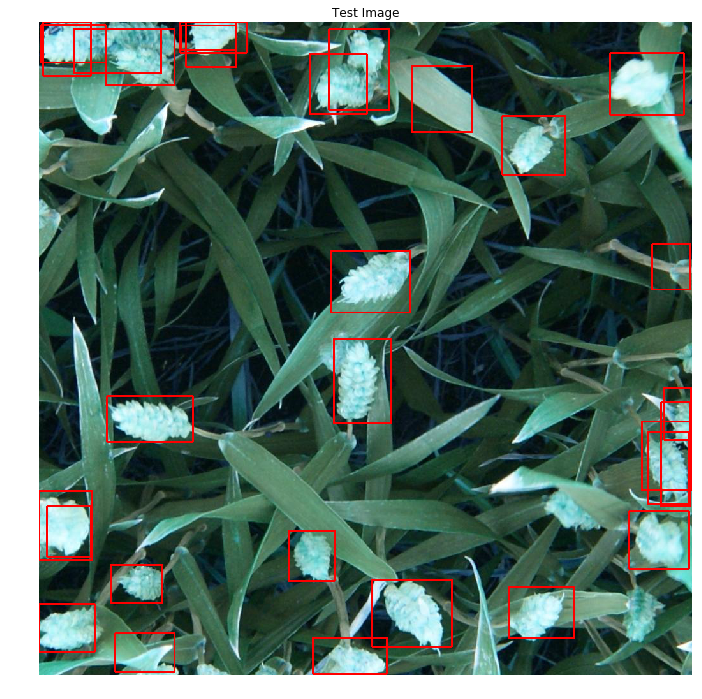

In [68]:
input_dir = "./global-wheat-detection/test"

plot_examples(inferences, all_files[0], input_dir)

Better, but we have some overlapping boundary boxes and clearly more non-max suppression is in order.